# Demo Notebook

### I. Import libraries and dependecies

In [1]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### A. Hyperparameter

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.0001
IMAGE_SIZE = (224, 224)
MODEL_PATH = "./common/model.pth"

In [3]:
# Current best
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001
IMAGE_SIZE = (224, 224)

#### B. Import Dataset and Preprocess

Custom Preprocessed Dataset

In [11]:
from data import LFWPProcessed

# Get mapper
mapper = {
    int(row["Target"]): str(row["Name"])
    for _, row in pd.read_csv("./data/lfw-py-processed/mapping.csv").iterrows()
}

train_dataset = LFWPProcessed("./data/lfw-py-processed/train")
test_dataset = LFWPProcessed("./data/lfw-py-processed/test")

Dataloader

In [89]:
train_loader = DataLoader(preprrocess_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(preprrocess_test_data, batch_size=BATCH_SIZE, shuffle=False)

##### Datatset: Face-31

In [90]:
# Preprocess
DIR_NAME = "data/face-31-preprocessed"
os.makedirs(DIR_NAME, exist_ok=True)

image_paths = []
labels = []
label_count = 0
label_unique = set()
label_dict = dict()
inv_dict = dict()

print("Processing data...")
data_source = pd.read_csv("data/face-31/Dataset.csv")
for idx, item in data_source.iterrows():
    if item["label"] not in label_unique:
        label_dict[label_count] = item["label"]
        inv_dict[item["label"]] = label_count
        label_count += 1
        label_unique.add(item["label"])

    image_paths.append(item["id"])
    labels.append(inv_dict[item["label"]])

    image_path = os.path.join("data/face-31/Faces", item["id"])
    save_path = os.path.join(DIR_NAME, "Faces", item["id"])
    # Preprocess
    image = np.asarray(Image.open(image_path))
    # Padding
    image = pad_img(image, 10)
    # Frontalization
    try:
        image = get_frontal(image)
    except Exception:
        pass
    # Resize to 224x224
    image = cv2.resize(image, (224, 224))
    # Convert back to PIL
    image = Image.fromarray(image.astype(np.uint8))
    # Save to path
    image.save(save_path)
    print(f"Progress: {idx + 1}/{len(data_source)}", end="\r")
pd.DataFrame(
    {
        "image": image_paths,
        "label": labels,
    }
).to_csv(os.path.join(DIR_NAME, "Dataset.csv"), index=False)
with open(os.path.join(DIR_NAME, "Mapping.json"), "w") as file:
    json.dump(inv_dict, file)
print("\nDone!")

Processing data...
Progress: 2562/2562
Done!


In [116]:
NUM_CLASSES = 31 # len(label_unique)
NUM_CLASSES

31

In [117]:
class PreprocessedFace31(Dataset):
    DIR_NAME = "data/face-31-preprocessed"

    def __init__(self, transform=None):
        self.transform = transform
        self.database = pd.read_csv(os.path.join(DIR_NAME, "Dataset.csv"))

    def __len__(self):
        return len(self.database)

    def __getitem__(self, idx):
        item = self.database.iloc[idx]
        image = item["image"]
        image_path = os.path.join(DIR_NAME, "Faces", image)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        target = item["label"]
        return image, target


composed = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

preprrocess_data = PreprocessedFace31(transform=composed)
train_size = int(len(preprrocess_data) * 0.8)
test_size = len(preprrocess_data) - train_size
train_data, test_data = random_split(preprrocess_data, [train_size, test_size])

In [118]:
train_loader = DataLoader(train_data,  batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

#### Visualize a batch

Batch size 32


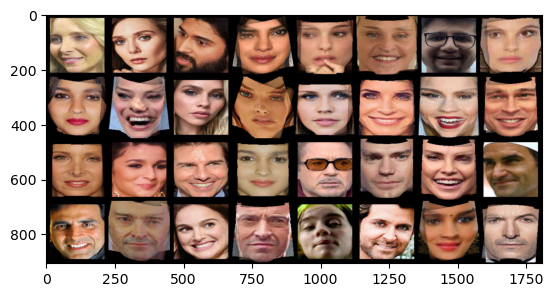

In [119]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batched[0]
    print("Batch size", len(images_batch))
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample in enumerate(train_loader):
    if i_batch == 0:
        show_batch(sample)
        break

#### C. Architecture

#### Past Model

In [95]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.flatten = nn.Flatten()
        self.batchnorm5 = nn.BatchNorm1d(256)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(in_features=13 * 13 * 256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)
        self.dropout = nn.Dropout(0.65)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Convo-block 1
        x = self.batchnorm1(self.relu(self.conv1(x)))
        x = self.batchnorm1(self.relu(self.conv2(x)))
        x = self.maxpool(x)
        # Convo-block 2
        x = self.batchnorm2(self.relu(self.conv3(x)))
        x = self.batchnorm2(self.relu(self.conv4(x)))
        x = self.maxpool(x)
        # Convo-block 3
        x = self.batchnorm3(self.relu(self.conv5(x)))
        x = self.batchnorm3(self.relu(self.conv6(x)))
        x = self.maxpool(x)
        # Convo-block 4
        x = self.batchnorm4(self.relu(self.conv7(x)))
        x = self.batchnorm4(self.relu(self.conv8(x)))
        x = self.maxpool(x)
        # Flatten
        x = self.flatten(x)
        # Dense
        x = self.batchnorm5(self.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


model = Net(NUM_CLASSES).to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 111, 111]               0
            Conv2d-8         [-1, 64, 111, 111]          18,496
              ReLU-9         [-1, 64, 111, 111]               0
      BatchNorm2d-10         [-1, 64, 111, 111]             128
           Conv2d-11         [-1, 64, 111, 111]          36,928
             ReLU-12         [-1, 64, 111, 111]               0
      BatchNorm2d-13         [-1, 64, 111, 111]             128
        MaxPool2d-14           [-1, 64,

#### Smaller Net

In [121]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.conv_1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(in_features=13 * 13 * 256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Convo-block 1
        x = self.relu(self.conv_1_1(x))
        x = self.relu(self.conv_1_2(x))
        x = self.maxpool(x)
        # Convo-block 2
        x = self.relu(self.conv_2(x))
        x = self.maxpool(x)
        # Convo-block 3
        x = self.relu(self.conv_3(x))
        x = self.maxpool(x)
        # Convo-block 4
        x = self.relu(self.conv_4(x))
        x = self.maxpool(x)
        # Flatten
        x = self.flatten(x)
        # Dense
        x = self.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x)
        x = self.relu(self.fc2(x))
        x = nn.Dropout(0.2)(x)
        x = self.softmax(x)
        return x


model = Net(NUM_CLASSES).to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 32, 224, 224]           9,248
              ReLU-4         [-1, 32, 224, 224]               0
         MaxPool2d-5         [-1, 32, 111, 111]               0
            Conv2d-6         [-1, 64, 111, 111]          18,496
              ReLU-7         [-1, 64, 111, 111]               0
         MaxPool2d-8           [-1, 64, 55, 55]               0
            Conv2d-9          [-1, 128, 55, 55]          73,856
             ReLU-10          [-1, 128, 55, 55]               0
        MaxPool2d-11          [-1, 128, 27, 27]               0
           Conv2d-12          [-1, 256, 27, 27]         295,168
             ReLU-13          [-1, 256, 27, 27]               0
        MaxPool2d-14          [-1, 256,

#### Training

In [122]:
loss_fn = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float("inf")

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    model.train()  # Turn on train mode for gradient updates
    train_loss = 0
    train_accuracy = 0
    batch = 0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        # Update metrics
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()
        batch += 1
        print(f"Epoch {epoch}: Batch {batch}/{len(train_loader)}", end="\r")
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    time_taken = time.time() - start_time

    model.eval()  # Turn on train mode to disable gradient updates
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = loss_fn(output, target)
            # Update metrics
            test_loss += loss
            pred = output.argmax(dim=1, keepdim=True)
            test_accuracy += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)

    # Log metrics
    print(
        f"Epoch {epoch}: Train Loss: {train_loss:.4f} | \
        Train Accuracy: {train_accuracy:.4f} | \
        Test Loss: {test_loss:.4f} | \
        Test Accuracy: {test_accuracy:.4f} | \
        Time taken: {time_taken:.4f}"
    )
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print("New best checkpoint saved!")

Epoch 1: Train Loss: 3.4335 |         Train Accuracy: 0.0317 |         Test Loss: 3.4278 |         Test Accuracy: 0.0507 |         Time taken: 71.4302
New best checkpoint saved!
Epoch 2: Train Loss: 3.4335 |         Train Accuracy: 0.0371 |         Test Loss: 3.4298 |         Test Accuracy: 0.0409 |         Time taken: 68.7998
Epoch 3: Train Loss: 3.4301 |         Train Accuracy: 0.0429 |         Test Loss: 3.4199 |         Test Accuracy: 0.0643 |         Time taken: 73.1949
New best checkpoint saved!
Epoch 4: Train Loss: 3.4282 |         Train Accuracy: 0.0493 |         Test Loss: 3.4146 |         Test Accuracy: 0.0526 |         Time taken: 63.2896
New best checkpoint saved!
Epoch 5: Train Loss: 3.4081 |         Train Accuracy: 0.0747 |         Test Loss: 3.3874 |         Test Accuracy: 0.1014 |         Time taken: 68.8118
New best checkpoint saved!
Epoch 6: Train Loss: 3.3851 |         Train Accuracy: 0.1005 |         Test Loss: 3.3904 |         Test Accuracy: 0.0897 |         Time t

In [1]:
from face_detection.face_parsing import FaceSegmentation
from face_detection.facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [5]:
mtcnn = MTCNN(keep_all=True, device="cuda")
seg = FaceSegmentation(device="cuda")

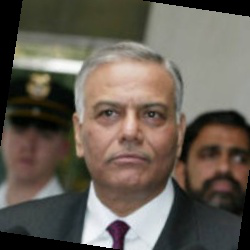

In [44]:
image = Image.open("./data/lfw-py/lfw_funneled/Yashwant_Sinha/Yashwant_Sinha_0002.jpg")
image

In [45]:
boxes, probs = mtcnn.detect(image)

In [53]:
boxes

array([[81.75204467773438, 70.4321060180664, 172.40032958984375,
        187.9545440673828],
       [188.5, 128.34213256835938, 253.20448303222656, 210.2285614013672],
       [-7.314670562744141, 102.33969116210938, 61.37568664550781,
        179.04383850097656]], dtype=object)

In [50]:
probs

array([0.9999988079071045, 0.9999991655349731, 0.999544084072113],
      dtype=object)

In [55]:
x1, y1, x2, y2 = (int(v) for v in boxes[1])
x1, y1 = max(x1, 0), max(y1, 0)
x2, y2 = min(x2, image_array.shape[0]), min(y2, image_array.shape[1])
image_array = np.asarray(image)
cropped = image_array[y1:y2, x1:x2]
cropped

array([[[19, 20, 12],
        [17, 20, 13],
        [12, 17, 10],
        ...,
        [11, 10,  6],
        [ 7,  8,  3],
        [ 6,  7,  1]],

       [[18, 19, 13],
        [17, 20, 13],
        [14, 19, 12],
        ...,
        [11, 10,  6],
        [ 7,  6,  2],
        [ 5,  6,  0]],

       [[17, 16, 11],
        [17, 18, 12],
        [17, 20, 13],
        ...,
        [16, 11,  7],
        [11,  8,  3],
        [ 6,  5,  0]],

       ...,

       [[21, 23, 22],
        [20, 24, 23],
        [21, 25, 24],
        ...,
        [ 1,  1,  3],
        [ 0,  0,  2],
        [ 0,  0,  2]],

       [[19, 23, 24],
        [19, 23, 24],
        [21, 25, 26],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  0,  2]],

       [[19, 23, 24],
        [19, 23, 24],
        [21, 25, 26],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  0,  2]]], dtype=uint8)

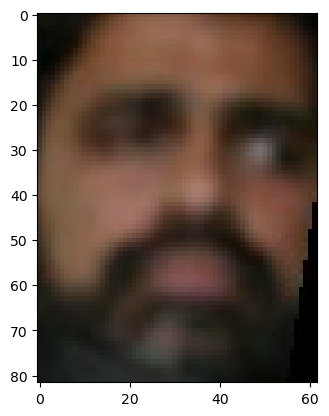

In [56]:
plt.imshow(cropped)

/tmp/ipykernel_428712/1173019528.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


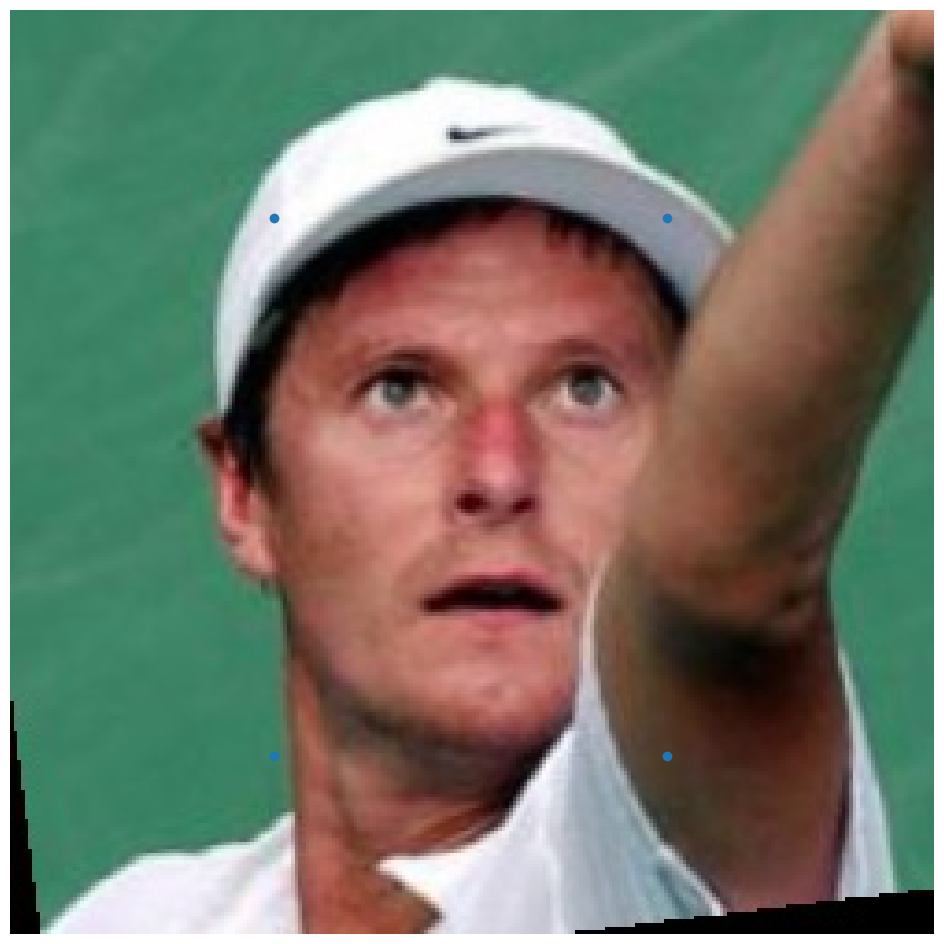

In [24]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(image)
ax.axis("off")

for box in boxes:
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
fig.show()

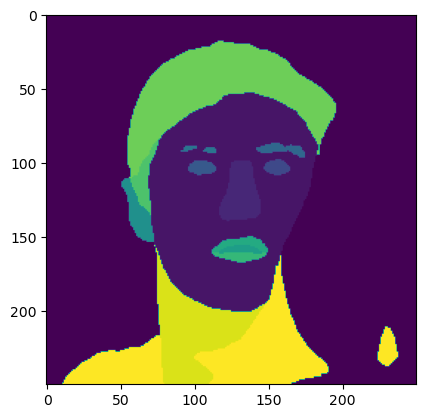

In [21]:
labels_viz = seg.get_mask(image)
plt.imshow(labels_viz)
plt.show()

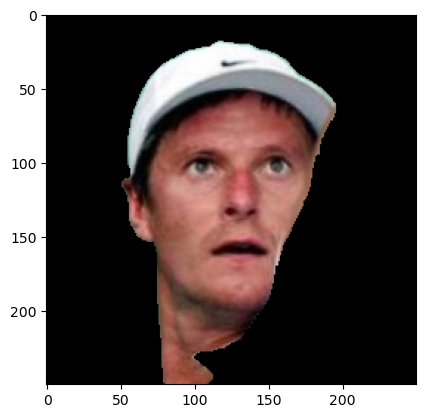

In [43]:
array = np.asarray(image)
mask = np.zeros(array.shape[:2], dtype=np.uint8)
mask[(labels_viz != 0) & (labels_viz != 18)] = 255
masked = cv2.bitwise_and(array, array, mask=mask)
plt.imshow(masked)